In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *
import os

In calculating workload, found that some departments in Oakland and DC have typos, overlaps, or are subcategories of each other. The mapping below was based on research in the 311 data portals interfaces and city government websites.

In [2]:
mapframe = pd.DataFrame([
    ('oakland','ROW_STREETSW','ROW'), # ROW = Right of Way. ROW_STREETSW = Right of Way Streets and Sidewalks, subcategory of ROW
    ('washington','TPPA','PPSA'), # both are PPSA, Policy Planning and Sustainability Administration
    ('washington','STREETLI','STREETLIGHT'), # typo of streetlight
    ('washington','SBM POTHOLES STREETT','POTHOLES'),
    ('washington','SBM POTHOLES ALLEY','POTHOLES'),
], columns=['city','department','new_department'])

mapframe

,city,department,new_department
0,oakland,ROW_STREETSW,ROW
1,washington,TPPA,PPSA
2,washington,STREETLI,STREETLIGHT
3,washington,SBM POTHOLES STREETT,POTHOLES
4,washington,SBM POTHOLES ALLEY,POTHOLES


In [3]:
files = os.listdir('../data/raw')
cities = set([f.split("_")[0] for f in files])

workloads = []

for c in cities:
    city = pd.DataFrame()
    print("loading:",c)
    for f in files:
        if c in f:
            tmp = pd.read_csv(
                f"../data/raw/{f}",
                parse_dates=['open_date','close_date'],
            )
            city = pd.concat([city,tmp]).reset_index(drop=True)
    city['city'] = c
    city = city.merge(mapframe, on=['city','department'], how='left')
    city.loc[city['new_department'].notna(),'department'] = city.loc[city['new_department'].notna(),'new_department']
    print(c,round(len(city[city['close_date'].isna()])/len(city)*100,2),"% close date missing")
    city = time_series_workload(city, c)
    city.to_csv(f"../data/processed/{c}_workload.csv", index=False)
    workloads.append(city)

loading: washington
washington 2.16 % close date missing


100%|██████████| 3731/3731 [05:18<00:00, 11.70it/s]


loading: boston
boston 7.55 % close date missing


100%|██████████| 3659/3659 [14:01<00:00,  4.35it/s]


loading: buffalo
buffalo 0.46 % close date missing


100%|██████████| 3766/3766 [04:34<00:00, 13.73it/s]


loading: miami
miami 37.26 % close date missing


100%|██████████| 3903/3903 [16:35<00:00,  3.92it/s]


loading: oakland
oakland 20.76 % close date missing


100%|██████████| 3766/3766 [04:42<00:00, 13.33it/s]


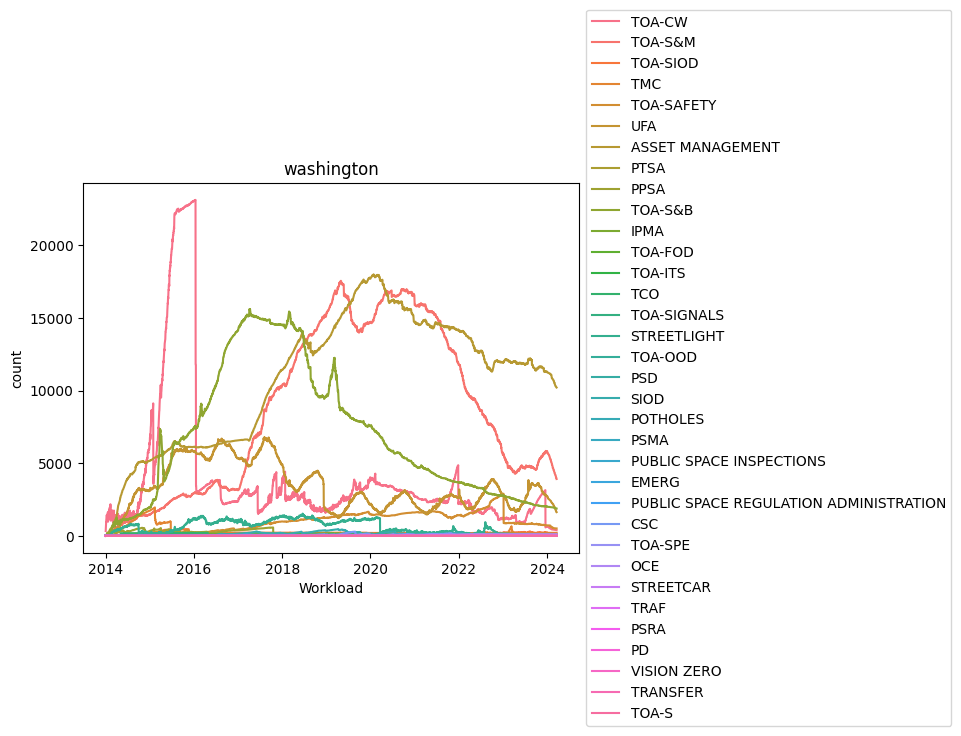

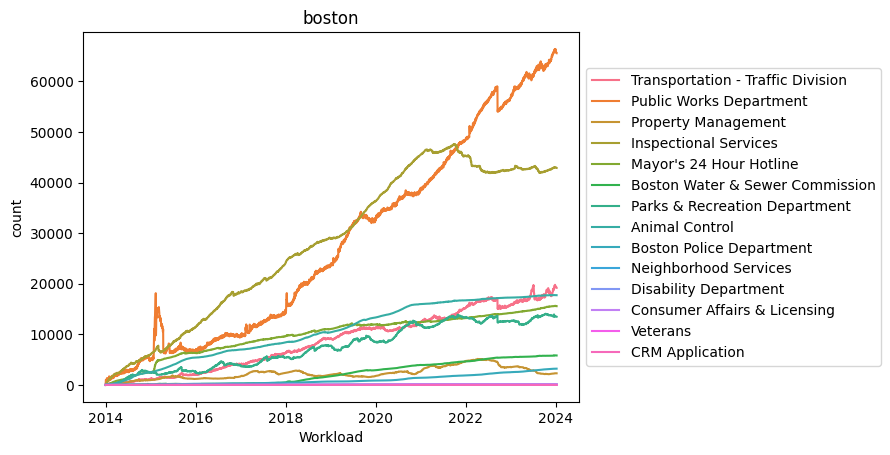

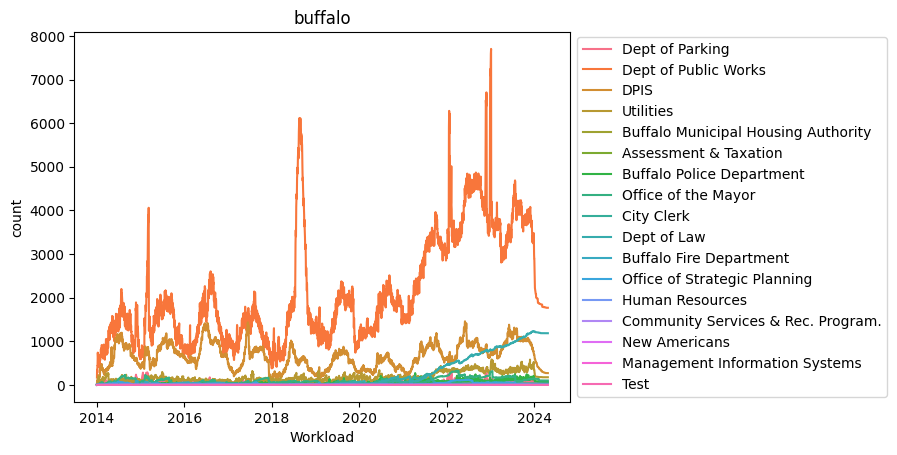

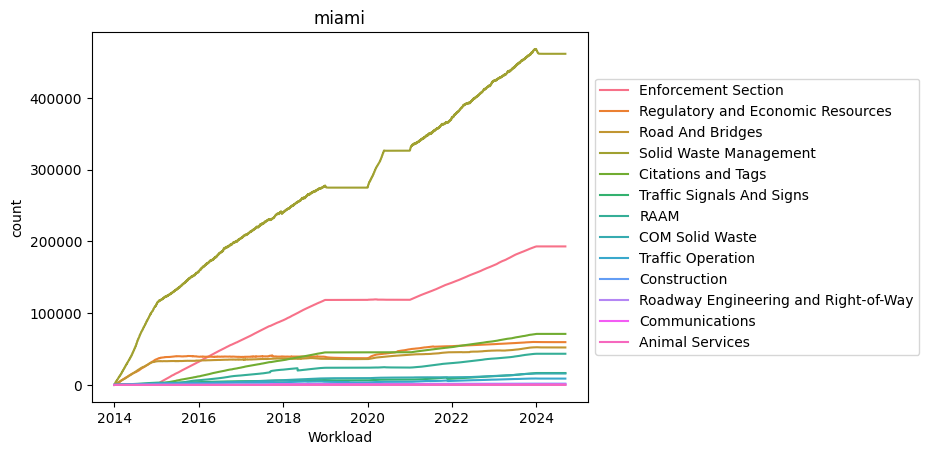

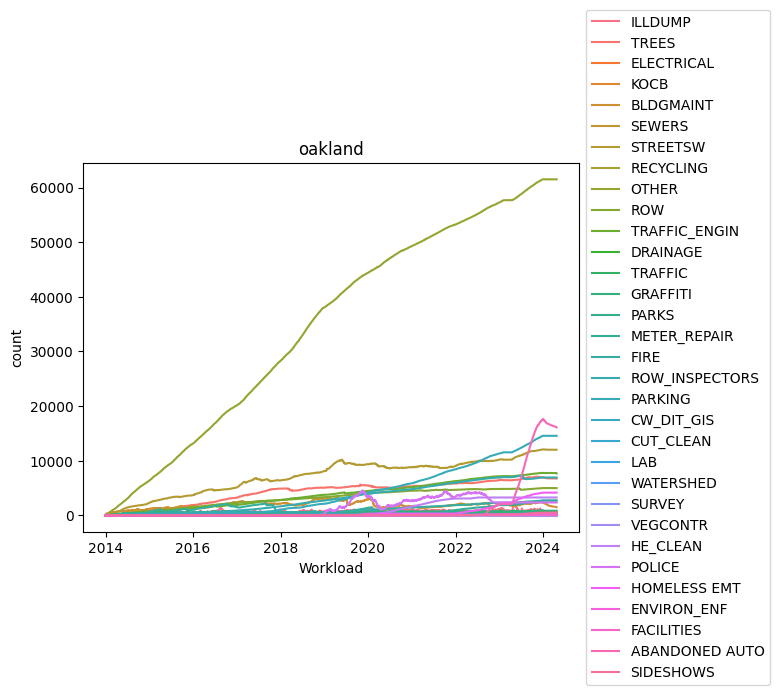

In [4]:
for w in workloads:
    plot = sns.lineplot(data=w, x="date", y="count", hue="department")
    plt.title(w['city'].unique()[0])
    plt.xlabel("Workload")
    plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
    plt.show()